## Strategies Investigation Notebook 1

#### So far this program investigates the potential exposure of each strategy via. Monte Carlo Simulation, and also investigates the percentage in growth from the brute force approach for each method!

### SETUP: Define all the programs we will use

#### Step 1: Import Modules

In [175]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import scipy
from scipy.stats import chisquare
import sys

#### Step 2: Define PSR Functions: currentExposure, addOn and totalExposure

In [176]:
def currentExposure(mtm):
    return max(0,mtm)


def addOn(notional, addOnFactor):
    return notional*addOnFactor


def totalExposure(mtm, notional, addOnFactor):
    currExp = currentExposure(mtm)
    currAddOn = addOn(notional, addOnFactor)

    return currExp + currAddOn

#### Step 3: Define the 4 different strategies 

In [177]:
def psrBruteForce(position, impacts, addOnFactor, bf_list):
    
    total = 0
    totalMtm = position[0]
    totalNotional = position[1]
    
    total += totalExposure(totalMtm, totalNotional, addOnFactor)
    bf_list.append(total)
    
    for i in range(len(impacts)):

        totalMtm += impacts[i,0]
        totalNotional += impacts[i,1]
        total = totalExposure(totalMtm, totalNotional, addOnFactor)
        bf_list.append(total)
    
    return bf_list


def psrConservative(position, impacts, addOnFactor, cons_list):
    total = 0
    total += totalExposure(position[0], position[1], addOnFactor)
    cons_list.append(total)

    for i in range(len(impacts)):
        total += totalExposure(impacts[i,0], impacts[i,1], addOnFactor)
        cons_list.append(total)

    return cons_list

def psrLinearisation(position, impacts, addOnFactor, lin_list):
    total = 0
    position_exposure = totalExposure(position[0], position[1], addOnFactor)
    total += position_exposure
    lin_list.append(position_exposure)

    for i in range(len(impacts)):
        total += totalExposure(position[0]+impacts[i,0], position[1]+impacts[i,1], addOnFactor) - position_exposure
        
        # We implement the workaround as dicussed below
        lin_list.append(max(0, total))

        # lin_list.append(total)

    return lin_list

def psrAverages(position, impacts, addOnFactor, n, avg_list):
    total = 0
    position_exposure = totalExposure(position[0], position[1], addOnFactor)
    total += position_exposure
    avg_list.append(position_exposure)

    for i in range(len(impacts)):
        total += 1/n*(totalExposure(position[0]+n*impacts[i,0], position[1]+n*impacts[i,1], addOnFactor) - position_exposure)
        avg_list.append(total)

    return avg_list



#### Step 5: Generate the dataset: Baseline Position + Incoming Trades

In [178]:
def get_position_impacts(n):
    
    baseline_position = [10000, 1000000]
    #baseline_position = [63000, 200]
    mtm_notional_matrix = np.zeros((n,2))

    
    for i in range(n):

        mtm_notional_matrix[i,0] = random.randint(-1000,1000)
        mtm_notional_matrix[i,1] = abs(mtm_notional_matrix[i,0])*10
        
        #mtm_notional_matrix[i,0] = random.randint(-2000,3000)
        #mtm_notional_matrix[i,1] = random.randint(-1000,1000)
        
    return [baseline_position, mtm_notional_matrix]

#### Step 6: Calculate Mean and Variance of the respective methods by analysing the distribution of values at 100th trade

In [179]:
def get_mean_variance(final_vals, samples):
    
    mu = []
    sigma = []
    std = []

    for i in range(final_vals.shape[0]):
        mu.append(np.sum(final_vals[i,:])/samples)

        current_mu = np.sum(final_vals[i,:])/samples

        std.append(np.std(final_vals[i,:]))

        diff_squared = np.sum((final_vals[i,:] - current_mu) ** 2)
        sigma.append(diff_squared / samples)
        
    return [mu,sigma, std]

#### Step 6a: Clean data by rounding float numbers to 4 decimal places

In [180]:
def remove_decimal_places(my_list):
    new_list = list(np.around(np.array(my_list), 4))
    return new_list

### PART 1: Monte Carlo Simulation of the strategies
#### In our first simulation, we investigate the distribution of the exposure strategies.
#### We generate a random dataset (baseline + positions) and input it into each exposure calculator. We repeat this process multiple times to get a distribution. 

#### Step 7: The big part: Simluate the exposure calculations using Monte Carlo

In [181]:
def exposure_simulation1(n, samples, addon, widget):

    x = np.linspace(0,n+1,n+1)
    final_vals = np.zeros((4,samples))

    fig,axs = plt.subplots(2,2, figsize=(10,8))
    fig.subplots_adjust(hspace=0.5) 
    fig.subplots_adjust(wspace=0.5) 

    for i in range(samples):
        bf_list = []
        lin_list = []
        cons_list = []
        avg_list = []


        [bl, matrix] = get_position_impacts(n)

        bf_result = psrBruteForce(bl, matrix, addon, bf_list)
        lin_result = psrLinearisation(bl, matrix, addon, lin_list)
        cons_result = psrConservative(bl, matrix, addon, cons_list)
        avg_result = psrAverages(bl, matrix, addon, n, avg_list)
        
        axs[0,0].plot(x,bf_result, c='r', label="Brute Force")
        axs[0,1].plot(x,lin_result, 'g', label="Linearisation")
        axs[1,0].plot(x,cons_result, 'b', label="Conservative")
        axs[1,1].plot(x,avg_result, 'y', label="Averages")
        

        final_vals[0,i] = bf_list[-1]
        final_vals[1,i] = lin_list[-1]
        final_vals[2,i] = cons_list[-1]
        final_vals[3,i] = avg_list[-1]


    axs[0,0].set_xlabel("Trade Number")
    axs[0,0].set_ylabel("Exposure")

    axs[1,0].set_xlabel("Trade Number")
    axs[1,0].set_ylabel("Exposure")

    axs[0,1].set_xlabel("Trade Number")
    axs[0,1].set_ylabel("Exposure")

    axs[1,1].set_xlabel("Trade Number")
    axs[1,1].set_ylabel("Exposure")
    
    axs[0,0].set_title("Brute Force")
    axs[0,1].set_title("Linearisation")
    axs[1,0].set_title("Conservative")
    axs[1,1].set_title("Averages")

    plt.show()
    
    if widget == False:
        return final_vals
    else:
        return None    


#### Step 8: Run the functions above, analyse the graphs, and inspect mean and variance of each method

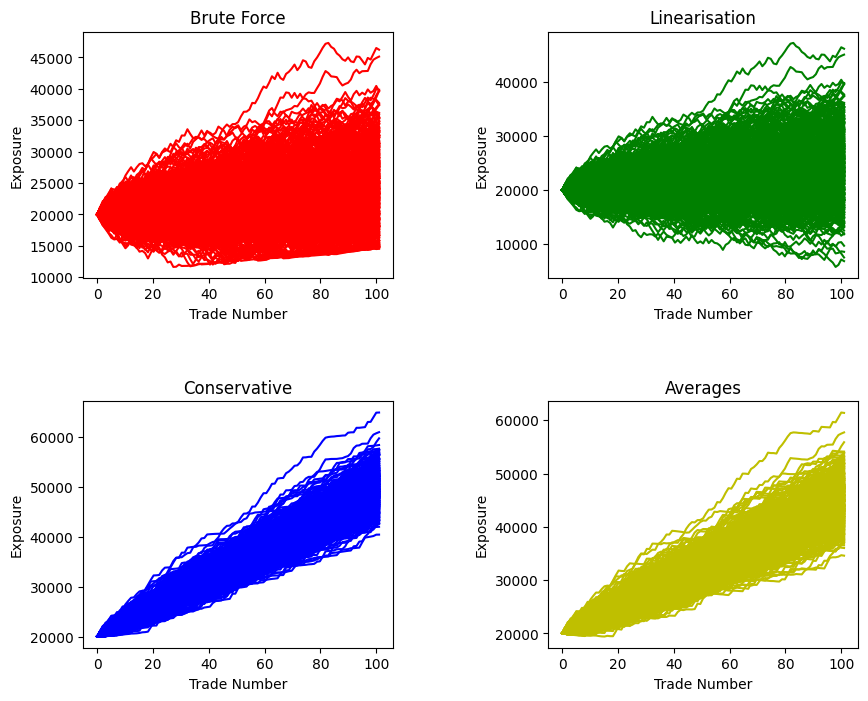

Entries below will correspond as follows : [Brute Force, Linearisation, Conservative, Averages]
Average Values at trade 100:  [24720.3526, 24613.6306, 49864.9206, 45098.4026]
Variance at trade 100:  [32958975.1634, 35512494.7808, 11733292.143, 14500524.9264]
Standard Deviation at trade 100:  [5740.9908, 5959.2361, 3425.3893, 3807.9555]


In [182]:
samples = 500
n = 100
addOnFactor = 0.01

final_vals = exposure_simulation1(n, samples, addOnFactor, False)

[mu,sigma,std] = get_mean_variance(final_vals, samples)

#print("Final Values: ", final_vals)

print("Entries below will correspond as follows : [Brute Force, Linearisation, Conservative, Averages]")
print("Average Values at trade 100: ", remove_decimal_places(mu))
print("Variance at trade 100: ", remove_decimal_places(sigma))
print("Standard Deviation at trade 100: ", remove_decimal_places(std))

#### INTERACT
##### Toggle the sliders below to investigate the growth rates yourself!

In [183]:
widgets.interact(exposure_simulation1, 
         n = widgets.IntSlider(min = 20 , max = 400, step = 1, value=100, description="No. of Trades"),
         samples = widgets.IntSlider(min=0,max=500,step=20,value=200,description="No. of Samples"),
         addon = widgets.FloatSlider(min=0, max = 1, value=0.01, step = 0.01, description="addOnFactor"),
         widget = True,
)

interactive(children=(IntSlider(value=100, description='No. of Trades', max=400, min=20), IntSlider(value=200,…

<function __main__.exposure_simulation1(n, samples, addon, widget)>

#### Step 8a: This is purely for fun, but we can show that the conservative approach follows an Arithmetic Brownian Motion (ABM). All we need to do is calculate the mean and standard deviation of Y = max(0,X) + 0.1*abs(X)

Mean of distribution: 299.88825428618026  Standard Deviation of distribution: 335.22197554391386


mu =  299.88825428618026
sigma =  335.22197554391386
Distribution of trades at trade 100 --> N( mu * t + X_0 , sigma^2 * t ) = N( 49988.82542861803 , 11237377.288756438 )


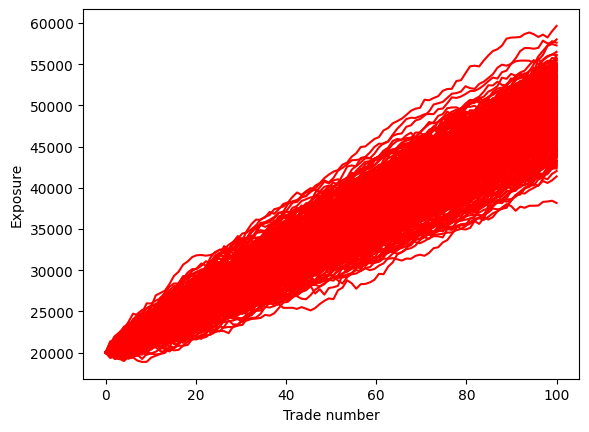

In [188]:

addonfactor = 0.01

np.random.seed(2020)

X = np.random.uniform(-1000,1000,10**5)

Y = [max(0,i) + addonfactor * 10 * abs(i) for i in X]

# This monte carlo simluates the mean and variance, but maybe also show how it's done by hand as well !

mu = np.mean(Y)
standard_dev = np.std(Y)

dt = 1

print("Mean of distribution: " + str(mu) + "  Standard Deviation of distribution: " + str(standard_dev))
print("\n")
T = 100  # T = Time <=> Trade 

n = int(T/dt)
t = np.linspace(0,T,n)

def run_sim():

    x = np.zeros(n)
    x[0] = 20000

    for i in range(n-1):
        # This is our ABM equation. There are more stochastic calculus notes on the paper. 
        x[i+1] = x[i] + mu*dt + standard_dev*np.random.normal(0,1)*np.sqrt(dt)
    
    return x

plt.figure()
for i in range(500):
    x = run_sim()

    plt.plot(t, x, 'r')


print("mu = ", mu)
print("sigma = ", standard_dev)
mu_T = mu*T
sigma_T = standard_dev ** 2 * T
print("Distribution of trades at trade 100 --> N( mu * t + X_0 , sigma^2 * t ) = N( " + str(mu*T + 20000) + " , " + str(standard_dev ** 2 * T) + " )")
plt.xlabel("Trade number")
plt.ylabel("Exposure")
plt.show()



### Part 2: Percentage Growth relative to Brute Force Method
#### The alternative strategies by definition overestimate the exposure, but by how much ?
#### The code below investigate the growth on an interactive graph, where you can see how the strategies work for different positions


In [185]:
def simulation_exposure_growth(n, addon, lin=True, cons=False, avg=False):


    bf_exposure_for_trade_i = []
    cons_exposure_for_trade_i = []
    lin_exposure_for_trade_i = []
    avg_exposure_for_trade_i = []

    for i in range(1,n):
        
        bf_list = []
        cons_list = []
        lin_list = []
        avg_list = []

        [bl, matrix] = get_position_impacts(i)

        bf_result = psrBruteForce(bl, matrix, addon, bf_list)
        lin_result = psrLinearisation(bl, matrix, addon, lin_list)
        cons_result = psrConservative(bl, matrix, addon, cons_list)
        avg_result = psrAverages(bl, matrix, addon, n, avg_list)


        bf_exposure_for_trade_i.append(bf_result[-1])
        cons_exposure_for_trade_i.append(cons_result[-1])
        lin_exposure_for_trade_i.append(lin_result[-1])
        avg_exposure_for_trade_i.append(avg_result[-1])


    diff_cons = [(cons_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    diff_lin = [(lin_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
    diff_avg = [(avg_exposure_for_trade_i[i]-bf_exposure_for_trade_i[i])/bf_exposure_for_trade_i[i] * 100 for i in range(len(bf_exposure_for_trade_i))]
        
        
        # We only want to take the last value of each iteration, this is the final exposure for each trade number


    x = np.arange(1,n)

    plt.figure(figsize=(8, 5))
    plt.grid(True)

    if lin == True:
        plt.plot(x[int(n/100):],diff_lin[int(n/100):],'r', label="Linearisation")
    
    if cons == True:
        plt.plot(x,diff_cons,'b', label="Conservative")

    if avg == True:
        plt.plot(x,diff_avg,'g', label="Averages")

    plt.xlabel("# of trades")
    plt.ylabel("% Diff. from Brute Force")
    plt.legend()
    plt.show()

        

#### Run the code using the ipywidgets module

In [186]:
widgets.interact(simulation_exposure_growth, 
         n = widgets.Play(min = 20 , max = 800, step = 20, interval=200),
         addon = widgets.FloatSlider(min=0,max=1,step=0.01,value=0.01,description="AddOnFactor"),
)

interactive(children=(Play(value=20, description='n', interval=200, max=800, min=20, step=20), FloatSlider(val…

<function __main__.simulation_exposure_growth(n, addon, lin=True, cons=False, avg=False)>